In [1]:
import random
import math

import numpy as np
import pandas as pd

from scipy.stats import beta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython import display

## Multi-Armed Bandit

by ololo


В этом туториале мы узнаем:

- Что такое многорукий бандит
- Как использовать теорему Байеса и Бета-распределение для решения этой задачи
- Как работает RTB реклама
- Что такое иерархические байесовы модели и как они используются для оптимизации рекламных показов
- Как сложить иерархическую модель с бандитом и получить иерархию бандитов


Начнем с небольшой теории.

**Многорукий бандит** (или "Multi-Armed Bandit", если по-английски) - это игровой автомат, у которого имеется несколько "рук". Мы за руку дергаем и выигрываем с какой-то вероятностью, например, $\theta_i$. Проблема в том, что вероятности нам не известны, поэтому мы хотим их выучить, взаимодействуя с бандитом, и при этом мы хотим свести количество проигрышей к минимуму.

Допустим, у нас 1000 попыток и 5 рук. Что можно сделать? Дернуть каждую руку по 10 раз, записать количество успешных исходов для каждой руки (т.н. "win rate"), а потом все оставшиеся 950 раз дергать за руку с наилучшими показателями.

Но вполне возможно, что нам просто повезло с какой-то рукой, и она просто по счастливой случайности выдала 10 выигрышей подряд. Такое ведь бывает, можно и монетку 10 раз подряд подбросить орлом верх.

Тогда поступим следующим образом: отведём специальный бюджет для исследования среды: допустим, на каждые 10 попыток, 9 будем дергать за самую везучую руку (по-английски говорят "exploit"), а еще раз дёрнем случайно одну из 4-х других рук (а это называется "explore"). Если в какой-то момент мы заметили, что какая-то другая рука более везучая - переключаемся на неё, и начинаем именно её дергать (то есть эксплуатировать) 9 из 10 раз.

Такой подход называется жадным подходом, или даже "$\varepsilon$-Greedy Bandit", где $\varepsilon$ - это параметр, бюджет, который мы отводим на исследование среды, в примере выше он равен 1/10 = 0.1, а все остальное время мы жадно дёргаем самую везучую руку.

Так вот, говорят, такой подход неоптимальный и ведет к печали (или "regret", если по-английски). Причина в том, что когда нам даётся возможность поэкспериментировать, мы случайно выбираем руку, совсем не руководствуясь тем, как она себя вела в прошлом. Может, это очень плохая рука, и мы зря на неё тратим бюджет, и лучше дёрнуть какую-нибудь другую руку. Нам хотелось бы печаль свести к минимуму, а радость - к максимуму. Естественно, в этом нам поможет Байес (и его последователь Томпсон).

**Байесовский Бандит** (или "Bayesian Bernoulli Bandit") использует теорему Байеса, поэтому давайте сначала её вспомним:

$$P(\theta \mid x) = \cfrac{P(x \mid \theta) \ P(\theta)}{P(x)}$$

Тут у нас есть несколько частей:

- $\theta$ - это вероятность успешного исхода, то есть вероятность выиграть, нам неизвестна.
- $x$ - исход взаимодействия с рукой бандита, успех или неудача (1 или 0), то, что мы можем увидеть. Именно это мы и используем, чтобы оценить $\theta$.
- $P(\theta)$ - априорная вероятность, или "prior" - наше предположение о том, как $\theta$ может быть распределена, это наши знания до того, как мы дернем руку
- $P(x \mid \theta)$ - вероятность исхода $x$, принимая во внимание всё то, что мы знали о $\theta$ на текущий момент, или "likelihood".
- $P(\theta \mid x)$ - апостериорная вероятность, "posterior" - то, как изменится наше представление о руке, после того как мы увидели реализацию $x$.
- $P(x)$ - полная вероятность наступления события $x$, не знаю, как по-английски, да и не важно это. Поэтому формулу чаще записывают таким образом:

$$P(\theta \mid x) \propto P(x \mid \theta) \ P(\theta)$$

То есть для нас важны prior и likelihood, а $P(x)$ - это просто нормализующий фактор, чтобы posterior был функцией плотности вероятности (то есть интеграл этой функции должен быть равен 1).

Так как исход у нас бинарный (удача/неудача), то моделировать исход $x$ будем с помощью функции Бернулли. Это наш likelihood:

$$P(x \mid \theta) = \theta^x \ (1 - \theta)^{1 - x}$$

В качестве приора обычно выбирают Бета-распределение (оно же Beta distribution), которое определяется двумя параметрами $\alpha$ и $\beta$:

$$P(\theta) = \cfrac{1}{B(\alpha, \beta)} \theta^{\alpha - 1} \ (1 - \theta)^{\beta - 1}$$

Почему именно Бета? Потому что Бета - сопряженное (conjugate) распределение с распределением Бернулли. То есть, если приор - Бета, а likelihood - Бернулли, то в результате у нас опять получится Бета. Это легко можно увидеть:

$$P(x \mid \theta) \times P(\theta) \propto \Big( \theta^x \ (1 - \theta)^{1 - x}\Big)  \times \Big(\theta^{\alpha - 1} \ (1 - \theta)^{\beta - 1}\Big) = \theta^{\alpha - 1 + x} \ (1 - \theta)^{\beta - 1 + (1 - x)}$$

(Мы тут опустили некоторые детали - их можно посмотреть в любом учебнике по терверу.)

То есть использование Беты позволяет нам очень легко обновлять апостериорное распределение:

- если у нас успех, $x = 1$, то $\alpha_\text{post} = \alpha + 1, \beta_\text{post} = \beta$,
- если у нас неудача, $x = 0$, то $\alpha_\text{post} = \alpha, \beta_\text{post} = \beta + 1$,
- $\alpha_\text{post}$ и $\beta_\text{post}$ тут - параметры апостериорного распределение.

После того, как мы дернули за руку и обновили параметры, апостериорное распределение становится априорным, и так после каждого эксперимента.

Теперь перейдем к самому бандиту. Итак, каждая рука у нас - это $\theta_i$, с приором $\text{beta}(\alpha_i, \beta_i)$, где

- $\alpha_i$ - это количество успешных исходов на текущий момент (+1),
- $\beta_i$ - количество неуспешных (тоже +1).

Перед тем, как мы дернули руку в самый первый раз, все $\alpha_i = \beta_i = 1$, что соответствует равномерному распределению от нуля до единицы - то есть мы совсем ничего о руках еще не знаем.

Теперь алгоритм такой:

- для каждой руки делаем выборку из $\theta_i \sim \text{beta}(\alpha_i, \beta_i)$
- выбираем руку, для которой значение семпла наибольшее, дёргаем именно за эту руку 
- наблюдаем результат, обновляем параметры для выбранной руки в зависимости от исхода
- повторяем пока не надоест

Этот алгоритм называется **Thompson Sampling** - именно такой способ обеспечивает оптимальное соотношение между expoitation и exploration, ведь в любой момент времени каждая рука может быть выбрана с ненулевой вероятностью, но не очень интересные руки будут выбраны реже. Мы увидем это ниже, когда реализуем бандита и посмотрим, как априорная вероятность меняется с течением времени. 

Если интересно как именно этот алгоритм минимизирует regret, то можно почитать "A Tutorial on Thompson Sampling" из списка источников. Или любую другую статью про бандитов, там тоже про это есть. 

### Реализация бандита

Давайте теперь реализуем это на питоне. Создадим класс `Arm` - это будет рука бандита, внутри которой мы будем считать, сколько у нас было успешных попыток, и сколько было попыток всего. В любой момент времени мы можем попросить руку посчитать вероятность успеха, а так же обновить параметры.

In [2]:
class Arm():
    def __init__(self):
        self.wins = 0
        self.trials = 0

    def sample(self):
        a = 1 + self.wins
        b = 1 + self.trials - self.wins
        return beta.rvs(a=a, b=b)

    def update(self, win):
        self.trials = self.trials + 1
        if win:
            self.wins = self.wins + 1

    def __repr__(self):
        return 'arm (%d/%d)' % (self.wins, self.trials)

Почему вместо `alpha` и `beta` мы храним в классе `wins` и `trials`? Так удобнее обычно, именно поэтому.

Бандит - это несколько рук, каждую из которых можно дёрнуть, поэтому давайте их сложим в список, это и будет наш бандит:

In [3]:
k = 3
bandit = [Arm() for i in range(k)]
bandit

[arm (0/0), arm (0/0), arm (0/0)]

Допустим, вероятность успеха рук задаётся следующим распределением:

In [4]:
probs =  [0.65, 0.5, 0.4]

Теперь реализуем Thompson Sampling: на каждом шагу мы семплим все руки и дергаем ту, вероятность которой наибольшая - согласно семплу. И обновляем статистику после каждого шага.

In [5]:
np.random.seed(4)
random.seed(4)

for i in range(100):
    sample = [a.sample() for a in bandit]
    best = np.argmax(sample)
    win = random.random() <= probs[best]
    bandit[best].update(win)

bandit

[arm (30/44), arm (17/33), arm (10/23)]

Во время работы мы попробовали дернуть вторую и третью ручки, но чаще всего эксплуатировали самую первую руку - 44 раз.

Давайте посмотрим, что происходит с распределениями. Для этого обнулим всю прошлую историю, и проследим, как априорное распределение каждой руки меняется с течением времени:

In [6]:
k = 3
bandit = [Arm() for i in range(k)]
bandit

[arm (0/0), arm (0/0), arm (0/0)]

In [7]:
!rm animation/*

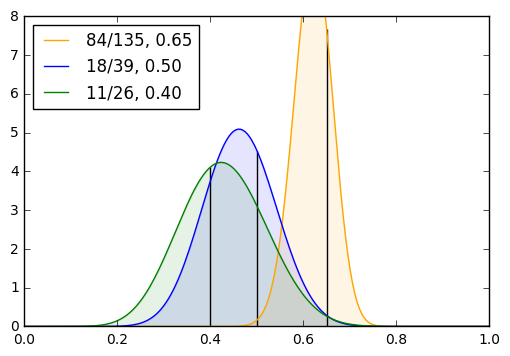

In [8]:
np.random.seed(4)
random.seed(4)

colors = ['orange', 'blue', 'green']
x = np.linspace(0, 1, 201)

for i in range(200):
    sample = [a.sample() for a in bandit]
    best = np.argmax(sample)
    win = random.random() <= probs[best]
    bandit[best].update(win)

    for p, arm, c in zip(probs, bandit, colors):
        a = 1 + arm.wins
        b = 1 + arm.trials - arm.wins

        pdf = beta.pdf(x, a=a, b=b)

        plt.plot(x, pdf, color=c, label='%d/%d, %0.2f' % (arm.wins, arm.trials, p))
        plt.fill_between(x, pdf, color=c, alpha=0.1)
        plt.vlines(p, 0, beta.pdf(p, a=a, b=b))


    plt.legend(loc='upper left')
    plt.ylim(0, 8)
    plt.savefig('animation/iteration_%03d.png' % i)
    plt.show()
    display.clear_output(wait=True)

In [9]:
!/usr/bin/convert -loop 0 -delay 10 animation/* out.gif

<img src="out.gif?01"/>

Сначала мы дёргали вторую руку чаще других, потому что думали, что она самая успешная, но со временем выяснили, что третья рука вообще-то лучше, поэтому потом переключились на неё. Если присмотреться, то видно, что пересечение между распределенями ненулевое. Это означает, что в любой момент времени любая другая рука имеет ненулевую вероятность быть выбранной.

## Реклама в RTB

С простым бандитом разобрались. Теперь давайте немного отвлечёмся от бандита и поговорим о рекламе - ведь именно там бандиты часто используются.

RTB, расшифровывается как Real Time Bidding, это режим аукционов в реальном времени. Каждый раз, когда пользователь открывает сайт с рекламой или приложение на телефоне, за кулисами за доли секунды разыгрывается небольшой аукцион, на котором рекламодатели соревнуются за возможность показать рекламу. 

Как это работает? Для примера рассмотрим рынок мобильной рекламы, но для веба и других рынков ситуация примерно такая же. 

Допустим, есть рекламодатель, который хочет порекламировать своё приложение, например, [Fidget Spinner](https://play.google.com/store/apps/details?id=com.ketchapp.fingerspinner) или какую-нибудь другую очень полезную программу для телефона. Рекламодатель обращается в DSP (Demand-Side Platform) - это компания, которая непосредсвенно участвует в аукционах, делает ставки и пытается продвинуть рекламируемое предложение. Это спрос на рекламу. Приложения, которые хотят у себя разместить рекламу, работают с SSP (Supply-Side Platform). SSP организуют аукционы, они создают предложение. SSP и DSP общаются друг с другом через RTB.

Итак, SSP торгует рекламными местами в приложениях клиентов. Каждый раз, когда пользователь открывает какое-нибудь приложение, например, Angry Birds, ему показывается реклама. Чтобы решить, какую рекламу показать, Angry Birds отправляет запрос в SSP, где указывает 

- своё имя (то есть Angry Birds),
- параметры рекламного места (баннер это или видео, размер баннера и т.п.),
- какие-то сведения о пользователе (страна, информация о девайсе, и т.п.).

SSP затем проводит аукцион (или не проводит, всякое бывает) - рассылает эту информацию нескольким DSP, каждый из которых назначает определённую цену за это рекламное место. Тот, кто больше всего заплатил, выигрывает возможность показать свою рекламу. После этого SSP отправляет эту рекламу обратно в приложение. В английской википедии (https://en.wikipedia.org/wiki/Online_advertising) про это достаточно подробно написано и красиво проиллюстрировано. 

Самое главное - всё это случается очень быстро, где-то в течение 100 мсек, поэтому если мы хотим использовать машин лернинг, наши модели должны уметь быстро регировать на запрос. То есть дип лернинг не получится использовать, но простые модели типа логистической регрессии - вполне. Про разные модели, которые используют в рекламе, можно почитать в книге "Display Advertising with Real-Time Bidding (RTB) and Behavioural Targeting". 

У логрега, однако, есть небольшой недостаток - он не очень хорошо умеет исследовать среду, exploration у него не очень, только exploitation есть. 

Попробую объяснить. Представим ситуацию - мы DSP и хотим участвовать в аукционе только тогда, когда вероятность клика высокая. Что мы делаем - тренируем модель, например, логрег, и говорим, что если модель предсказывает вероятность клика ниже какого-то порога (например, 0.02), то мы просто не участвуем в аукционе. 

Но 0.02 (2%) - это очень большое число для рекламы, большинство пользователей не кликает на рекламу вообще, поэтому 
таким образом мы отфильтруем большую часть входящего траффика. Вроде бы хорошо - мы тратим деньги только на потенциально полезных юзеров, которые нам принесут доход. 

Но есть одно "но" - когда мы захотим натренировать новую обновленную модель со свежими данными - модель увидит только часть данных! То есть мы откинем большую часть данных, и совсем не будем знать, что там происходит - вдруг часть этих юзеров изменят своё поведение? Мы об этом никогда не узнаем. Гугл про это даже статью написал, "Machine Learning: The High Interest Credit Card of Technical Debt", там они эту проблему называют "Hidden Feedback Loops".

Можно попытаться решить проблему таким образом - если модель отдаёт предсказание выше порога, то мы ведем себя как обычно и участвуем в аукционе. Если ниже - то мы участвуем в аукционе с какой-нибудь вероятностью, например, 0.01. Таким образом мы только что изобрели аналог $\varepsilon$-Greedy бандита, только для логрега. У которого такое же проблемы - вероятность среди плохих и более многообещающих пользователей одинаковая. 

Для бандитов эту проблему мы решили с помощью семплирования из Бета-распределения. Мы можем сделать то же самое! 

## Hierarchical Models

В ситуации с логрегом всё понятно - у нас есть какой-то набор признаков, типа страна, модель телефона, приложение, из которого приходит запрос, имя SSP, мы все это дело обрабатываем через One Hot Encoding, возможно взвешиваем признаки через TF-IDF или BM25, а потом запускаем `lr.fit(X, y)`. Всё, модель готова, можно интегрировать в прод. 

С Бетой немного сложнее. Представим, что у нас есть несколько наблюдений:

- `[ru, iphone, angry_birds, 1]`
- `[us, iphone, grindr, 0]`
- `[ru, android, pornhub, 1]`

Что можно сделать? Можно представить, что каждый набор признаков вида (страна, платформа, приложение) - это что-то типа "руки" бандита. То есть каждый такой набор помнит количество кликов и имеет своё распределение $\text{beta}(\alpha_i, \beta_i)$.

Приходит новый запрос, мы находим соотвествующую бету, берём из неё семпл, и говорим, что это и есть наш CTR. Если он больше порога, то мы участвуем в аукционе, меньше - не участвуем. Проблема логрега таким образом решается, потому что семпл может быть разным, и иногда он может оказаться выше порога. Логрег (по крайней мере обычный) так не умеет - он всегда предсказывает одну и ту же вероятность.

Теперь представим, что появилось новое приложение, "Beta Bandits", и мы получили запрос вида `[ru, iphone, beta_bandits]`. Что делать? Информации про это приложение у нас нет, поэтому мы заводим новую бету с параметрами `(1, 1)` и начинаем собирать статистику по этому приложению. Но ведь у нас уже есть информация по пользователям из России с айфонами! Наверняка она была бы полезной, но с такой моделью мы никак эту информацию не можем использовать. А логрег бы смог.

Для решения этой проблемы мы можем объединить признаки в иерархию. Например, так:

In [10]:
import graph_utils # файл graph_utils.py в этой же папке

tree = {
    'market': {
        'ru': {
            'iphone': ['angry_birds', 'beta_badits'],
            'android': ['pornhub']
        },
        'us': {
            'iphone': ['grindr'],
        }, 
    }
}

g = graph_utils.tree_to_dot(tree)
g.write_png('hierarchy.png');

<img src="hierarchy.png?11"/>

Идея такая: более общие признаки находятся выше в иерархии, менее общие - ниже. Когда приходит запрос, мы спускаемся вниз по дереву, если каких-то признаков в пути нет, то мы добавляем нужные вершины. 

Каждая вершина этого графа хранит количество успехов и неудач, то есть $\alpha_i$ и $\beta_i$, которые мы используем для семлирования. Но перед тем, как сгенерировать предсказание, мы запрашиваем информацию у родительской вершины о её успехах и неудачах. Таким образом, если у нас появилась новая вершина, такая как "beta_badits", мы сможем воспользоваться накопленой статистикой из родительской вершины "iphone". Если вдруг появится какой-то пользователь с убунтуфоном, или, хуже того, с windows, мы добавим сразу две новые вершины в граф - "windows" и вершину с названием приложения. В этом случае мы воспользуемся статистикой, которую собрали в вершине "ru".

Каким же образом вершины графа могут воспользоваться информацией из родителя? Конечно, с помощью приоров. 

В обычной ситуации, когда родителя нет, наша модель такая:

- likelihood: $y \mid \theta \sim \text{bernoulli}(\theta)$
- prior: $\theta \sim \text{beta}(\alpha, \beta)$

А когда есть родитель $\theta_p \sim \text{beta}(\alpha_p, \beta_p)$, то мы можем подключить параметры родителя следующим образом:

- likelihood: $y \mid \theta \sim \text{bernoulli}(\theta)$
- prior: $\theta \mid \alpha_p, \beta_p \sim \text{beta}(\alpha + \alpha_p, \beta + \beta_p)$

Однако когда в родителе накапливается достаточно большое количество статистики, значения родителя начинают "перекрывать" значения в ребёнке. 

Допустим, родитель хранит информацию о $N_p = \alpha_p + \beta_p$ испытаниях. Мы можем уменьшить влияние родителя, сделав семпл из испытаний родителя размера $n$, при этом $n$ должен быть небольшим числом. Таким образом, сначала, когда у ребёнка нет достаточной информации, мы пользуемся данными от родителя, но со временем он накопит достаточно данных, чтобы перекрыть приор родителя.

Как сделать такой семпл? Например, так:

- генерируем число $\theta_p \sim \text{beta}(\alpha_p, \beta_p)$
- принимаем его за среднее значение желаемого семла
- тогда, $\theta_p = \alpha'_p\, / \, (\alpha'_p + \beta'_p)$, $n = \alpha'_p + \beta'_p$
- из этого считаем $\alpha'_p = \theta_p \, n$, $\beta'_p = (1 - \theta_p) \, n$

Теперь передаём именно эти значения $\alpha'_p$ и $\beta'_p$ ребёнку, поэтому приор у нас получается таким:

- $\theta \mid \alpha'_p, \beta'_p \sim \text{beta}(\alpha + \alpha'_p, \beta + \beta'_p)$
- $\alpha'_p = \theta_p \, n$ и $\beta'_p = (1 - \theta_p) \, n$
- $\theta_p \sim \text{beta}(\alpha_p, \beta_p)$

В такой модели $n$ - это гиперпараметр, его обычно фиксируют. Он так же может быть случайной величиной, но тогда модель будет сложнее.

Обновление в этой модели такое же, как у руки бандита: если пользователь в итоге кликнул, то мы увеличиваем параметр $\alpha$, если нет - то $\beta$. Отличие от рук состоит в том, что тут мы обновляем статистику у всех вершин, которые были на пути от корня дерева до листа. Если наши признаки были `[ru, iphone, angry_birds]`, то мы обновим счётчики для корня дерева, `ru`, `iphone` и `angry_birds`.

И последнее, когда мы просим родителя дать нам информацию, нужно быть осторожным, чтобы случайно не посчитать одни и те же данные два раза. 

Представим, что в нашем графе только две вершины - родитель и ребёнок. Тогда ребёнку нет смысла просить родителя об информации, ведь у родителя нет ничего, о чём бы ребенок ещё не знал сам. 

А теперь представим другую ситуацию: у нас всего четыре вершины, родитель и три ребёнка. Тогда, когда первый ребёнок запрашивает информацию, то родитель должен использовать только данные, полученные от второго и третьего. Это делается очень легко: перед тем, как семплировать $\theta_p$, мы для генерации используем $\alpha = \alpha_p - \alpha_1$ и $\beta = \beta_p - \beta_1$, где $p$ - это параметры родителя, а $1$ - первого ребёнка.

### Реализация

Давайте теперь реализуем это на питоне. Создадим класс `Node` со следующими параметрами:

- `parent` - родительская вершина, у которой мы будем просить информацию, и
- `downsample_size` - это $n$, про который мы писали выше.

Как и в случае с бандитом, вместо `alpha` и `beta` мы храним `wins` и `trials`. 

Основные методы класса:

- `sample_params_from_parent` - попросить родителя посчитать $\alpha'_p$ и $\beta'_p$
- `sample` - вернуть семпл, почти как в бандите, но только ещё мы внутри вызываем `sample_params_from_parent`,
- `update` - обновляет значения `wins` и `trials`.

Так же у нас есть второстепенные методы:

- `beta_params` - перевести `wins` и `trials` в $\alpha$ и $\beta$,
- `no_data_in_parents` - проверить, есть ли у родителя какие-то данные, которых у нас ещё нет. Если есть, то можно просить параметры, а иначе смысла нет,
- `total_trials` - посчитать общее количество попыток в модели.

Так это выглядит в коде:

In [11]:
class Node():
    def __init__(self, name, parent=None, downsample_size=200):
        """
        name: имя вершины
        parent: родитель вершины, None если нет родителя
        downsample_size: размер выборки при семплировании параметров из родителя,
            по умолчанию наследуется от родительской вершины
        """
        self.parent = parent

        if parent is not None:
            self.downsample_size = parent.downsample_size
        else:
            self.downsample_size = 200

        self.name = name
        self.wins = 0
        self.trials = 0

    def sample_params_from_parent(self, silent):
        """
        делает выборку из родителя размером downsample_size и считает alpha и beta на основе этой выборки
        если родителя нет, или у родителя нет данных, то возвращает alpha=0, beta=0

        silent: вывод логов, False если нужны логи
        """
        parent = self.parent
        if parent is None:
            return 0, 0

        if self.no_data_in_parents():
            return 0, 0

        sample_size = min(self.downsample_size, self.total_trials())
        parent_mean = parent.sample(w=self.wins, t=self.trials, silent=silent)

        a_prior = parent_mean * sample_size
        b_prior = sample_size - a_prior

        if not silent:
            print('prior %s->%s is %.3f: α=%.3f, β=%.3f' % (self.name, parent.name, parent_mean, a_prior, b_prior))

        return a_prior, b_prior

    def sample(self, w=0, t=0, silent=True):
        """
        Семплируем из вершины
        Параметры w и t нужны, чтобы не учитывать одни и те же данные из ребёнка и родителя 
        (см описание в тексте выше)

        w: количество успеных исходов, которые мы не хотим учитывать при семплировании 
        t: общее количество экспериментов, которые мы не хотим учитывать при семплировании
        silent: вывод логов, False если нужны логи
        """
        a_prior, b_prior = self.sample_params_from_parent(silent)

        a, b = self.beta_params()
        a = a - w
        b = b - (t - w)

        a_post = a + a_prior
        b_post = b + b_prior
        
        res = beta.rvs(a=a_post, b=b_post)

        if not silent:
            print('sampling %.4f from %s with α=%.3f, β=%.3f' % (res, self.name, a_post, b_post))

        return res

    def update(self, wins, trials):
        """
        обноваляет статистику вершины и всех родителей

        wins: количество успешных исходов
        trials: общее количество исходов
        """
        self.wins = self.wins + wins
        self.trials = self.trials + trials

        if self.parent is not None:
            self.parent.update(wins, trials)

    def beta_params(self):
        """
        переводит wins и trials в alpha и beta для семплирования из Бета-распределения
        """
        a = 1 + self.wins
        b = 1 + (self.trials - self.wins)
        return a, b

    def no_data_in_parents(self):
        """
        проверяем, есть ли у родителя данные, про которые мы не знаем.
        если нет - то нам нет необходимости запрашивать у него информацию
        """
        parent = self.parent
        if parent is None:
            return True

        if parent.trials == self.trials:
            return parent.no_data_in_parents()
        else:
            return False
        
    def total_trials(self):
        """
        общее количество попыток в графе
        """
        parent = self.parent
        if parent is None:
            return self.trials

        return parent.total_trials()

    def sample_multiple(self, size):
        """
        делаем выборку размера size с текущими параметрами wins/trials и параметрами родителя
        size: размер выборки
        """
        sample = []

        for i in range(size):
            s = self.sample(silent=True)
            sample.append(s)

        return sample

Теперь давайте попробуем эту модель в действии. 
Для иллюстрации, конечно же, возьмем пример рекламы. Но немного упростим - опустим часть с аукционом и представим, что у нас есть возможность покупать рекламные показы небольшими пачками по 500-2000 штук за раз.

Представим ситуацию: компания "Horns & Hooves Ltd" - рекламодатель, который рекламирует игру  "Mushroom Farm". Мы можем купить рекламный траффик из двух других приложений, пусть это будут Grindr и Fidget Spinner, назовём их `app1` и `app2`. Мы хотим оценить, как активно пользователи этих приложений кликают на нашу рекламу - то есть мы хотим посчитать CTR. 

Сначала мы хотим рекламировать наш апп в США. Пусть CTR в первом приложении в Штатах будет 0.06, а во втором - 0.07, но мы об этом не знаем и хотим эту вероятность выучить.

Сделаем такую иерархию: сначала модель для всего рынка, потом для США, а потом для каждого приложения:

In [12]:
market = Node('market', downsample_size=200)

us = Node('us', parent=market)
app1_us = Node('app1', parent=us) # 0.06
app2_us = Node('app2', parent=us) # 0.07

Для наших экспериментов напишем специальную функцию `simulate_traffic`, которая в качестве параметра берёт вершину и эмулирует определённое количество попыток с заданной вероятностью успеха. После этого функция нарисует красивые (я надеюсь) графики, по которым мы сможем понять, как модель себя вела. 

In [13]:
def beta_std(a, b):
    var = a * b / ((a + b) ** 2 * (a + b + 1))
    return math.sqrt(var)

def simulate_traffic(node, prob, trials, silent=True, seed=1):
    np.random.seed(seed)
    random.seed(seed)
    samples = []
    means = []
    stds = []

    for i in range(trials):
        s = node.sample(silent=silent)
        samples.append(s)

        a, b = node.beta_params()
        means.append(a / (a + b))

        std = beta_std(a, b)
        stds.append(std)

        w = int(random.random() <= prob)
        node.update(w, 1)

    samples = pd.Series(samples)
    means = np.array(means)
    stds = np.array(stds)

    plt.fill_between(np.arange(trials), means - 1.9 * stds, means + 1.9 * stds, alpha=0.05)
    plt.plot(means, color='blue', alpha=0.5, )

    plt.plot(samples, alpha=0.2, color='blue')
    plt.plot(samples.rolling(10).mean(), color='black')
    
    plt.hlines(prob, 0, trials)

    plt.ylim(0, 0.2)

Сейчас мы купили 1000 рекламных показов в `app1` и смотрим, что происходит:

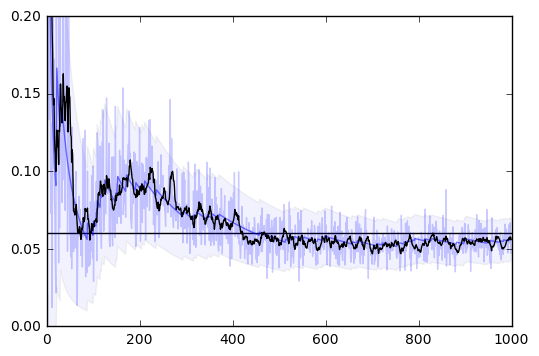

In [14]:
simulate_traffic(app1_us, 0.06, 1000, seed=2)

На этом графике у нас много информации:

- вертикальная линия - это 0.06, реальный CTR, 
- синяя линия - мат.ожидание Бета-распределения на основе истории, $\mu = \alpha \, / \, (\alpha + \beta)$
- фон вокруг синей линии - $\mu \pm 1.9 \, \sigma$, где $\sigma$ - среднеквадратическое отклонение, а $\mu$ - мат.ожидание
- бледная гобуая линия - семплы из $\theta \sim \text{beta}(\alpha, \beta)$
- черная линия - скользящее среднее семплов


Видно, что ближе к 1000-му показу мы достаточно точно приблизились к 0.06. Чтобы как-то приблизиться к 0.06, нам понадобилось около 500 показов. 

Теперь давайте покажем рекламу 500 раз в другом приложении, CTR которого немного выше:

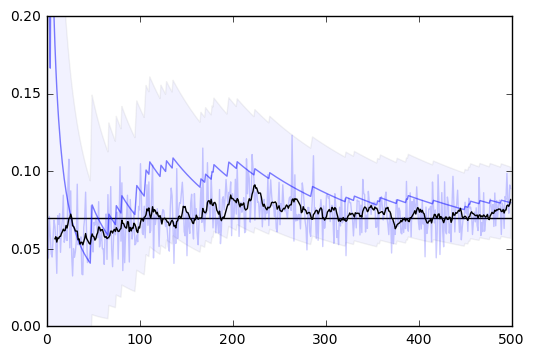

In [15]:
simulate_traffic(app2_us, 0.07, 500, seed=4)

Так как у нас родительская нода (`us`) знает, как вёло себя `app1`, мы можем воспользоваться этой информацией для предсказаний значений для `app2`. Видно, что модель сначала выдает предсказания в районе 0.06, на основе данных от родителя, а потом начинает ползти вверх.

Давайте еще раз покажем рекламу 1000 раз в первом приложении:

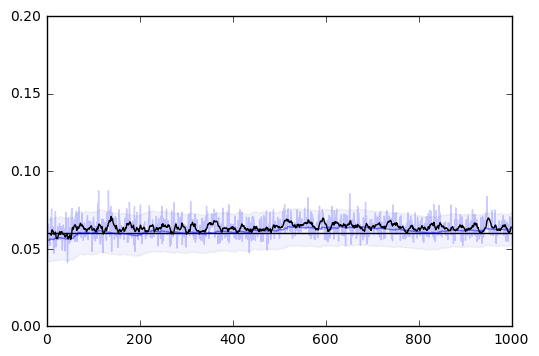

In [16]:
simulate_traffic(app1_us, 0.06, 1000, seed=5)

Траффик из второго приложения не сильно изменил поведение модели для первого приложения. Так же видно, что не смотря на то, что центр распределения (который $\mu$) уже сошелся около настоящего значения в 0.06, модель продолжает "эксперементировать", выдавая разные значения вокруг центра. 

Давайте посмотрим, какие значения выдаёт модель при зафиксированных параметрах:

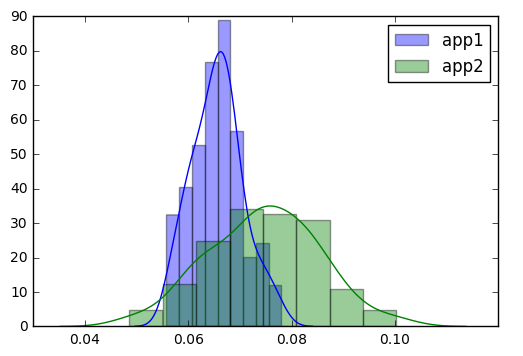

In [17]:
sns.distplot(app1_us.sample_multiple(100), label='app1')
sns.distplot(app2_us.sample_multiple(100), label='app2')
plt.legend();

Так как в `app1` показов было больше, чем в `app2`, то модель для этого приложения более уверена в предсказаниях (дисперсия ниже).

Теперь давайте представим, что мы решили запустить рекламу в России:

In [18]:
ru = Node('ru', parent=market)
app1_ru = Node('app1', parent=ru) # 0.03
app2_ru = Node('app2', parent=ru) # 0.02

Допустим, CTR в России ниже, чем в Америке: 0.03 и 0.02 соотвественно. Но пока мы об этом не знаем. Посмотрим, какие значения предложит наша модель для нового рынка:

0.076369207547950693

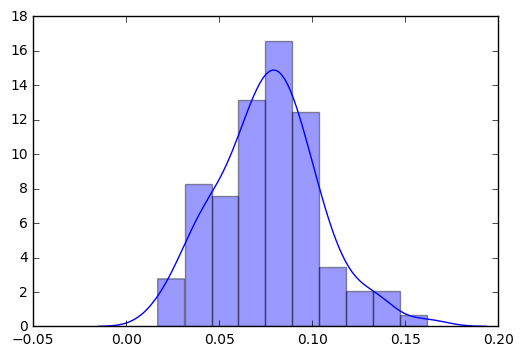

In [19]:
sample = app1_ru.sample_multiple(100)
sns.distplot(sample)
np.mean(sample)

Ожидаемо, модель руководсвуется данными, полученными на американском рынке. Давайте теперь покажем рекламу 2000 раз в `app1` в России:

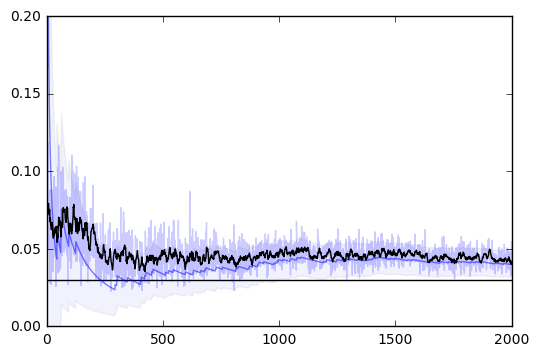

In [20]:
simulate_traffic(app1_ru, 0.03, 2000, seed=6)

Различия на рынках достаточно существенные, поэтому требуется некоторое время, чтобы приблизиться к значению 0.03.

Давайте внимательнее посмотрим, что происходит, когда мы просим модель сделать предсказание:

In [21]:
np.random.seed(1)
app1_ru.sample(silent=False)

sampling 0.0752 from market with α=166.000, β=2336.000
prior ru->market is 0.075: α=15.035, β=184.965
sampling 0.0740 from ru with α=16.035, β=185.965
prior app1->ru is 0.074: α=14.804, β=185.196
sampling 0.0515 from app1 with α=94.804, β=2107.196


0.051481056835183933

Видно, как мы берем приор у корня дерева (0.07), но он постепенно уменьшается, и так итоге доходит до значения 0.05.

Теперь мы решили показать рекламу 500 раз в приложении 2:

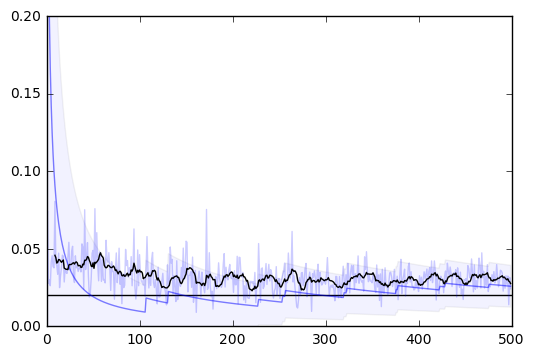

In [22]:
simulate_traffic(app2_ru, 0.02, 500, seed=7)

На этот раз у нас уже достаточно данных о том, как ведет себя реклама в России, поэтому почти сразу модель начинает выдавать предсказания ближе к реальному CTR.

In [23]:
np.random.seed(2)
app2_ru.sample(silent=False)

sampling 0.0643 from market with α=166.000, β=2336.000
prior ru->market is 0.064: α=12.863, β=187.137
sampling 0.0356 from ru with α=92.863, β=2109.137
prior app2->ru is 0.036: α=7.111, β=192.889
sampling 0.0229 from app2 with α=20.111, β=681.889


0.022918070152353431

При такой схеме добавлять новые вершины в граф совсем несложно. Например, мы можем легко добавить еще одну страну:

In [24]:
ua = Node('ua', parent=market)
app1_ua = Node('app1', parent=ua)
app2_ua = Node('app2', parent=ua)

Так как данных по этой стране ещё нет, то при решении модель руководствуемся данными от родительских вершин.
Сделаем семпл из одной из новых вершин и сравним его с другими вершинами:

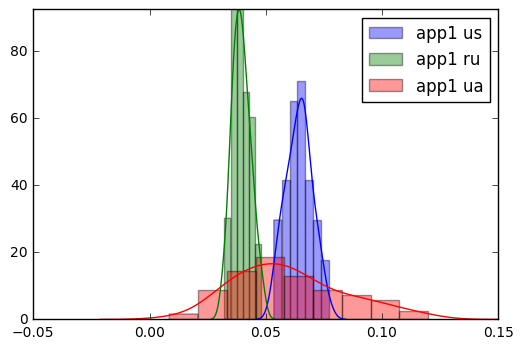

In [25]:
np.random.seed(1)

sns.distplot(app1_us.sample_multiple(50), label='app1 us')
sns.distplot(app1_ru.sample_multiple(50), label='app1 ru')
sns.distplot(app1_ua.sample_multiple(100), label='app1 ua')

plt.legend();

Так как данных в этих вершинах у нас еще нет, то данные мы берём из родителя. Разброс, который мы тут получаем, регулируется параметром `downsample_size` - именно он позволяет указать, каким сильным будет влияние родителя на ребенка. В теории этот параметр мы называли $n$. Чем $n$ выше - тем больше влияние родителя на детей. Можно поменять его и посмотреть, что будет:

In [26]:
ua.downsample_size = 5000
app1_ua.downsample_size = 5000

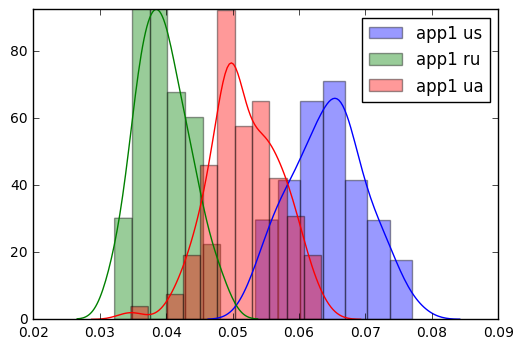

In [27]:
np.random.seed(1)

sns.distplot(app1_us.sample_multiple(50), label='app1 us')
sns.distplot(app1_ru.sample_multiple(50), label='app1 ru')
sns.distplot(app1_ua.sample_multiple(100), label='app1 ua')

plt.legend();

В этом случае влияние выше, поэтому дисперсия ниже, и значения сильнее сконцентрированы вокруг среднего значения родителя. Однако такой приор будет сложнее "побить" - потребуется много данных, чтобы статистика самой вершины начала преобладать над приором.

# Hierarchical Bandit

Но это у нас не совсем бандит получился - а просто иерархическая модель. Конечно, можно представить, что это всё-таки был бандит, а руки - это все возможные комбинации признаков. В ситуации с покупкой траффика из конкретного приложения (тот пример, который мы рассматривали выше) это может даже работать: мы дергаем за "руку", находим наиболее многообещающую комбинацию, покупаем показы, обновляем статистику и так повторяем пока не закончатся деньги. 

В ситуации с RTB всё немного иначе. Допустим, мы DSP и кроме "Horns & Hooves Ltd" у нас есть много других клиентов. Для каждого клиента мы проводим рекламную кампанию по продвижению их приложения.

Вот приходит с биржи запрос, в котором говорится, что приложение - это "Angry Birds", страна США и ещё что-нибудь. То есть получается, что признаки зафиксированы, мы никак не можем их поменять, поэтому это не рука, а что-то, что мы не контролируем. Но мы можем выбрать, какую именно кампанию использовать для того, чтобы отреагировать на входящий запрос. То есть мы можем рассматривать кампании, как руки бандита, и дёргать (то есть показывать) именно ту кампанию, которая по нашему с бандитом мнению наиболее многообещающая. 

Как это реализовать? Есть несколько вариантов.

Первый вариант - добавить кампанию как признак на какой-нибудь из уровней иерархической модели. Это может быть любой уровень, он может идти сразу после корня, может идти после страны, или даже быть в самом конце. Приходит запрос - мы подставляем значения всех кампаний, которые мы знаем, а потом ту "дёргаем" кампанию, для которой вывод был наибольший. 

Второй вариант - создать индивидуальную модель на каждую кампанию. Тогда берём семпл из каждой модели и выбираем кампанию с наибольшим значением. Прямо как обычный бандит, только рука у нас сложнее, с иерархией. 

Для этого варианта, да и частично для первого, есть проблема - что делать, когда мы начинаем новую кампанию? Тут тоже можно проявить креативность. Например, можно взять кампанию, которая больше всего похожа на нашу, сделать копию модели, и использовать её. При этом можно обнулить статистики в листьях, чтобы они не сильно мешали изучать среду. Можно взять среднее всех сущесвующих кампаний, тоже обнулить статистику в листьях. Можно обнулять не только листья, но и родителей этих листев, и даже родителей родителей. 

Реализовывать это мы тут не будем, вроде не должно быть сильно сложно.

Естественно, не получится просто взять код выше и запустить в прод. Есть несколько моментов, над которыми нужно подумать, прежде чем это делать. 

Например:

- Разговаривать со всеми родительскими вершинами может быть долго, особенно если граф получается большой. Поэтому можно каким-либо образом заранее насемлить значений для каждого листа (например, используя функцию `sample_multiple`), а потом обновлять модель сразу батчем, например, каждые 20 минут.
- Если бандит работает какое-то продолжительное время, то он узнает много информации, которую неплохо было бы забывать с течением времени. Поэтому клики, которым больше недели, можно выкинуть. Существует много способов это сделать - например пересчитывать параметры в вершинах или добавлять exponential decay. Второе я никогда не пробовал, а первое можно довольно легко реализовать.
- Писать это лучше не на питоне, а на чём-нибудь типа C++ или Java. Кстати, семплер для beta из scipy довольно медленный, есть более эффективные реализации. 

На этом, пожалуй, всё. Не забываем ставить плюсики.

## Источники и ссылки

- Multi-Armed Bandits: https://dataorigami.net/blogs/napkin-folding/79031811-multi-armed-bandits
- Understanding Bayes: Updating priors via the likelihood: https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/
- Bayesian hierarchical modeling: https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling
- A Tutorial on Thompson Sampling: https://arxiv.org/abs/1707.02038
- Display Advertising with Real-Time Bidding (RTB) and Behavioural Targeting: https://arxiv.org/abs/1610.03013
- Machine Learning: The High Interest Credit Card of Technical Debt: https://research.google.com/pubs/pub43146.html 